# Brain Tumor MRI: Comprehensive Error Analysis

**Objective:** Identify systematic patterns in classification errors to guide future model improvements.

**Methodology:**
1. Error collection on test set.
2. Distribution analysis by class.
3. Confidence analysis on erroneous predictions.
4. Visual gallery of difficult cases.
5. Evidence-based recommendations.

In [1]:
import sys
import os

sys.path.append("..")  # To import from src/

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import cv2

# Visualization configuration
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 11

# Import project utilities
from src.utils import load_config

print("✅ Imports completed")

I0000 00:00:1765710823.364269  422627 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1765710823.398057  422627 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1765710824.275478  422627 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1765710824.275478  422627 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results d

✅ Imports completed


In [2]:
# Configuration
cfg = load_config("../configs/config.yaml")
class_names = cfg["data"]["class_names"]
img_size = cfg["data"]["image_size"]

# Load BASE MODEL
model_base_path = "../models/best.keras"
if not os.path.exists(model_base_path):
    raise FileNotFoundError(
        "❌ Base model not found. Run first: python src/train.py"
    )
model_base = tf.keras.models.load_model(model_base_path, compile=False)
print(f"✅ BASE model loaded from: {model_base_path}")

# Load FINE-TUNED MODEL
model_ft_path = "../models/finetuned_navoneel.keras"
if not os.path.exists(model_ft_path):
    print(f"⚠️ Fine-tuned model not found: {model_ft_path}")
    print(
        "   Only the base model will be analyzed. Run: python tools/train_finetune.py"
    )
    model_ft = None
else:
    model_ft = tf.keras.models.load_model(model_ft_path, compile=False)
    print(f"✅ FINE-TUNED model loaded from: {model_ft_path}")

print(f"   Classes: {class_names}")

# Preprocessing according to backbone
if "v2" in cfg["model"]["name"]:
    preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input
else:
    preprocess_input = tf.keras.applications.efficientnet.preprocess_input

W0000 00:00:1765710825.312728  422627 gpu_device.cc:2362] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
E0000 00:00:1765710825.349890  422627 util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


✅ BASE model loaded from: ../models/best.keras
✅ FINE-TUNED model loaded from: ../models/finetuned_navoneel.keras
   Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
✅ FINE-TUNED model loaded from: ../models/finetuned_navoneel.keras
   Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


## 1. Comparative Analysis: Base Model vs Fine-Tuned

We analyze errors on the **External Dataset (Navoneel)** with both models.
This is the dataset where we observe the real domain shift problem.

In [3]:
# Use EXTERNAL dataset (Navoneel) - the medically processed one
external_dir = Path("../data/external_navoneel_medical")

if not external_dir.exists():
    print(f"⚠️ External dataset not found: {external_dir}")
    print("   Using internal dataset for demonstration...")
    external_dir = Path(cfg["data"]["test_dir"])

print(f"🔍 Analyzing EXTERNAL dataset: {external_dir}")
print(f"   This dataset has DOMAIN SHIFT relative to training\n")

# Index of no_tumor
try:
    no_tumor_idx = class_names.index("no_tumor")
except ValueError:
    no_tumor_idx = -1


# Helper function to map binary labels from Navoneel to multiclass
def navoneel_folder_to_binary(folder_name):
    """Converts 'yes'/'no' from Navoneel to 0/1"""
    if "yes" in folder_name.lower():
        return 1  # Tumor
    else:
        return 0  # Healthy


# Collect predictions from BOTH models
errors_base = []  # Base model errors
errors_ft = []  # Fine-tuned model errors
all_predictions = []  # All predictions for comparison

print("Processing images from external dataset...")

# Navoneel has structure: external_navoneel_medical/yes/* and external_navoneel_medical/no/*
for folder_name in ["yes", "no"]:
    folder_path = external_dir / folder_name

    if not folder_path.exists():
        print(f"⚠️  Folder {folder_name} not found, skipping...")
        continue

    true_binary = navoneel_folder_to_binary(folder_name)  # 0=Healthy, 1=Tumor

    image_files = list(folder_path.glob("*.jpg")) + list(folder_path.glob("*.png"))

    print(f"   Processing {len(image_files)} images from '{folder_name}'...")

    for img_path in tqdm(image_files, desc=f"  {folder_name}", leave=False):
        try:
            # Read and preprocess
            img = cv2.imread(str(img_path))
            if img is None:
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img_rgb, (img_size, img_size))
            x = preprocess_input(img_resized[None].astype(np.float32))

            # BASE MODEL PREDICTION
            logits_base = model_base.predict(x, verbose=0)[0]
            probs_base = tf.nn.softmax(logits_base).numpy()

            # Convert multiclass prediction → binary
            pred_binary_base = 0 if probs_base[no_tumor_idx] > 0.5 else 1
            confidence_base = float(
                probs_base[no_tumor_idx]
                if pred_binary_base == 0
                else 1 - probs_base[no_tumor_idx]
            )

            # FINE-TUNED MODEL PREDICTION (if exists)
            pred_binary_ft = None
            pred_class_ft = None
            confidence_ft = None
            if model_ft is not None:
                logits_ft = model_ft.predict(x, verbose=0)[0]
                probs_ft = tf.nn.softmax(logits_ft).numpy()
                pred_binary_ft = 0 if probs_ft[no_tumor_idx] > 0.5 else 1
                pred_class_ft = "Tumor" if pred_binary_ft == 1 else "Healthy"
                confidence_ft = float(
                    probs_ft[no_tumor_idx]
                    if pred_binary_ft == 0
                    else 1 - probs_ft[no_tumor_idx]
                )

            # Save case
            case = {
                "path": str(img_path),
                "filename": img_path.name,
                "true_binary": true_binary,
                "true_class": "Tumor" if true_binary == 1 else "Healthy",
                "pred_binary": pred_binary_base,
                "pred_class": "Tumor" if pred_binary_base == 1 else "Healthy",
                "confidence": confidence_base,  # Alias for compatibility
                "conf_base": confidence_base,
                "pred_ft": pred_binary_ft,
                "pred_class_ft": pred_class_ft,
                "conf_ft": confidence_ft,
            }

            all_predictions.append(case)

            # Save ERRORS
            if pred_binary_base != true_binary:
                errors_base.append(case)

            if pred_binary_ft is not None and pred_binary_ft != true_binary:
                errors_ft.append(case)

        except Exception as e:
            print(f"      Error processing {img_path.name}: {e}")
            continue

# Create DataFrames
df_all = pd.DataFrame(all_predictions)
df_errors_base = pd.DataFrame(errors_base)
df_errors_ft = pd.DataFrame(errors_ft) if model_ft else pd.DataFrame()

print(f"\n{'=' * 70}")
print(f"COMPARATIVE ANALYSIS SUMMARY")
print(f"{'=' * 70}")
print(f"Total images analyzed: {len(df_all)}")
print(f"\n📊 BASE MODEL:")
print(
    f"   Errors: {len(df_errors_base)} / {len(df_all)} ({len(df_errors_base) / len(df_all):.1%} error rate)"
)
print(f"   Accuracy: {(1 - len(df_errors_base) / len(df_all)):.1%}")

if model_ft:
    print(f"\n📊 FINE-TUNED MODEL:")
    print(
        f"   Errors: {len(df_errors_ft)} / {len(df_all)} ({len(df_errors_ft) / len(df_all):.1%} error rate)"
    )
    print(f"   Accuracy: {(1 - len(df_errors_ft) / len(df_all)):.1%}")
    print(
        f"\n✅ IMPROVEMENT: {len(df_errors_base) - len(df_errors_ft)} fewer errors ({((len(df_errors_base) - len(df_errors_ft)) / len(df_errors_base)):.1%} reduction)"
    )
else:
    print(f"\n⚠️ Fine-tuned model not available for comparison")

🔍 Analyzing EXTERNAL dataset: ../data/external_navoneel_medical
   This dataset has DOMAIN SHIFT relative to training

Processing images from external dataset...
   Processing 87 images from 'yes'...


   Processing 86 images from 'no'...



COMPARATIVE ANALYSIS SUMMARY
Total images analyzed: 173

📊 BASE MODEL:
   Errors: 44 / 173 (25.4% error rate)
   Accuracy: 74.6%

📊 FINE-TUNED MODEL:
   Errors: 43 / 173 (24.9% error rate)
   Accuracy: 75.1%

✅ IMPROVEMENT: 1 fewer errors (2.3% reduction)


## 2. Error Analysis Dashboard

We visualize error patterns from multiple perspectives.


📊 Error Comparison:
   Base Model: 44 errors
   Fine-Tuned Model: 43 errors
   Improvement: 1 errors corrected


✅ Comparative dashboard saved: reports/error_comparison_dashboard.png

✅ Comparative dashboard saved: reports/error_comparison_dashboard.png


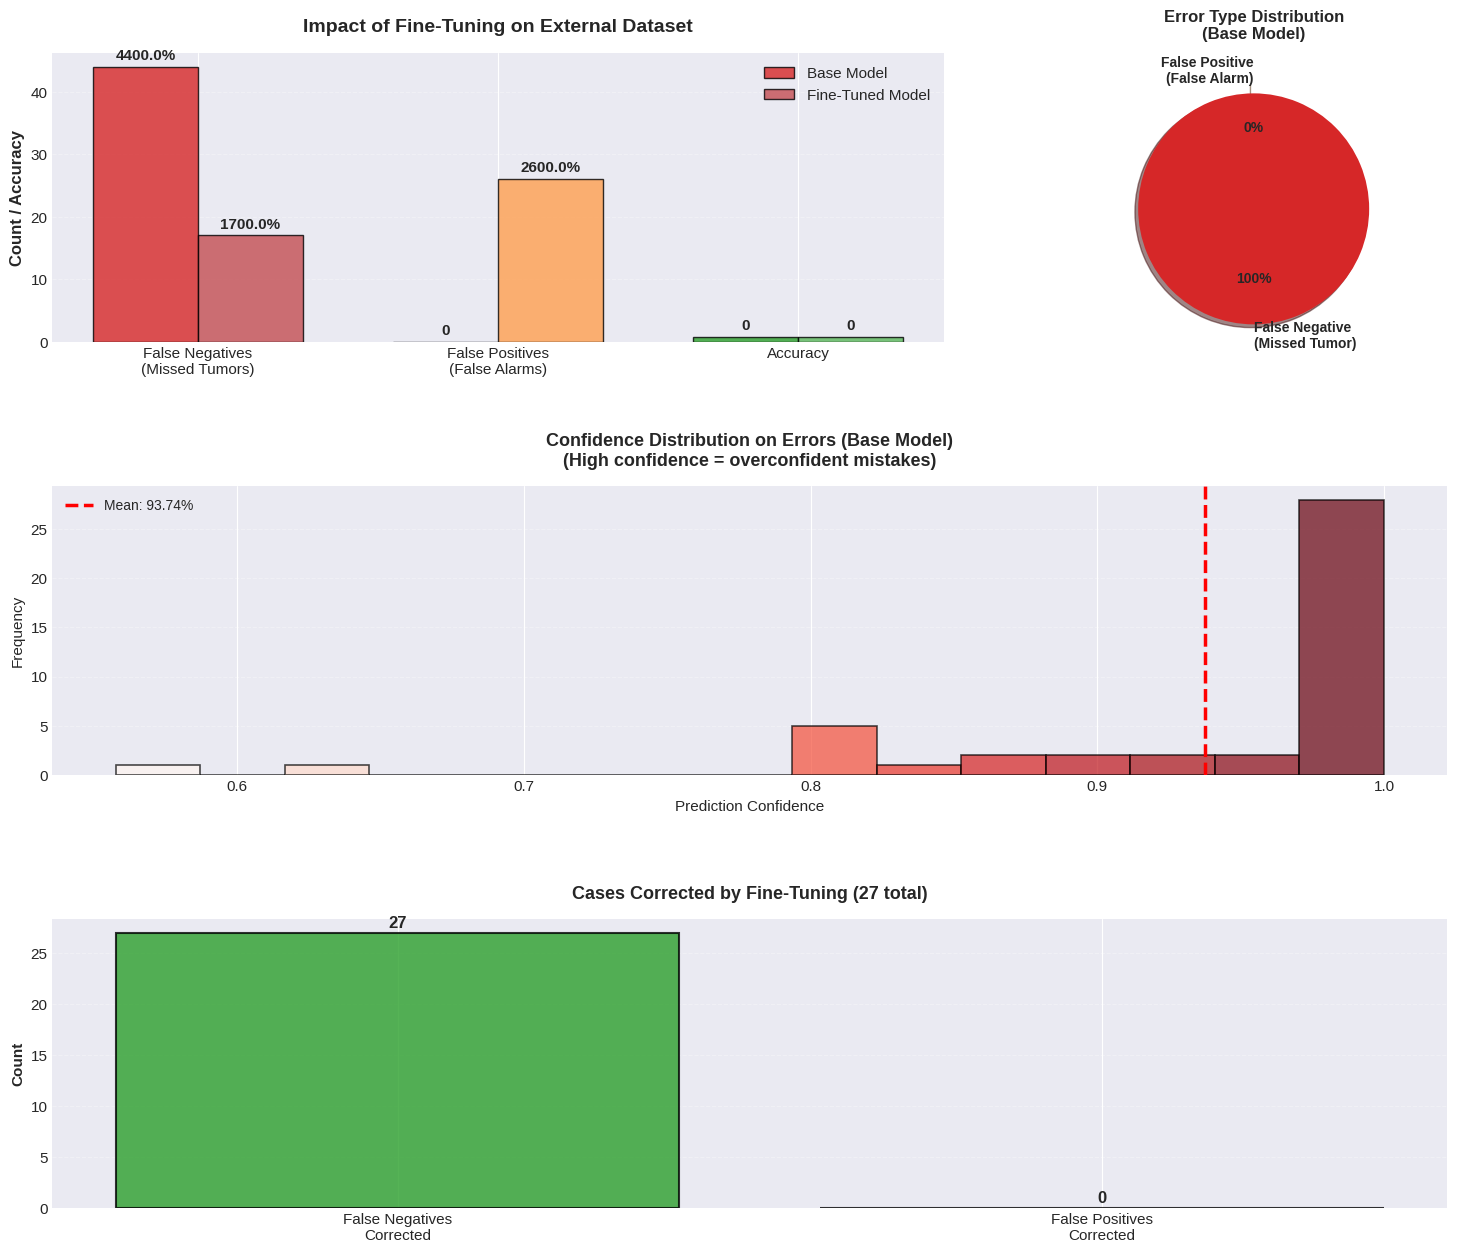

In [4]:
# Decide which model to analyze in detail (the one with more errors is more interesting)
# Initialize df_errors to avoid reference errors
df_errors = df_errors_base

if len(df_errors_base) == 0:
    print("🎉 The base model has 100% accuracy on the external dataset!")
    print("   No errors to analyze.")
elif model_ft is None:
    print("⚠️ Only analyzing the base model (fine-tuned not available)")
    df_errors = df_errors_base  # For compatibility with rest of code
else:
    # Analyze both models
    print(f"\n📊 Error Comparison:")
    print(f"   Base Model: {len(df_errors_base)} errors")
    print(f"   Fine-Tuned Model: {len(df_errors_ft)} errors")
    print(f"   Improvement: {len(df_errors_base) - len(df_errors_ft)} errors corrected\n")

    # We use the BASE model for detailed analysis (shows the original problem)
    df_errors = df_errors_base

if len(df_errors) > 0:
    fig = plt.figure(figsize=(18, 15))
    gs = fig.add_gridspec(3, 3, hspace=0.5, wspace=0.3)

    # ========== Chart 1: Base vs Fine-Tuned Comparison ==========
    if model_ft is not None:
        ax = fig.add_subplot(gs[0, :2])

        # Calculate metrics per model
        total = len(df_all)

        # Confusion matrices
        from sklearn.metrics import confusion_matrix

        cm_base = confusion_matrix(df_all["true_binary"], df_all["pred_binary"])
        cm_ft = confusion_matrix(df_all["true_binary"], df_all["pred_ft"])

        # Metrics
        tn_base, fp_base, fn_base, tp_base = cm_base.ravel()
        tn_ft, fp_ft, fn_ft, tp_ft = cm_ft.ravel()

        metrics = [
            "False Negatives\n(Missed Tumors)",
            "False Positives\n(False Alarms)",
            "Accuracy",
        ]
        base_vals = [fn_base, fp_base, (tp_base + tn_base) / total]
        ft_vals = [fn_ft, fp_ft, (tp_ft + tn_ft) / total]

        x = np.arange(len(metrics))
        width = 0.35

        bars1 = ax.bar(
            x - width / 2,
            base_vals,
            width,
            label="Base Model",
            color=["#d62728", "#ff7f0e", "#2ca02c"],
            alpha=0.8,
            edgecolor="black",
        )
        bars2 = ax.bar(
            x + width / 2,
            ft_vals,
            width,
            label="Fine-Tuned Model",
            color=["#c44e52", "#ff9f50", "#5cb85c"],
            alpha=0.8,
            edgecolor="black",
        )

        ax.set_ylabel("Count / Accuracy", fontsize=12, fontweight="bold")
        ax.set_title(
            "Impact of Fine-Tuning on External Dataset",
            fontsize=14,
            fontweight="bold",
            pad=15,
        )
        ax.set_xticks(x)
        ax.set_xticklabels(metrics, fontsize=11)
        ax.legend(fontsize=11, loc="upper right")
        ax.grid(axis="y", alpha=0.3, linestyle="--")

        # Add values on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                label = f"{int(height)}" if height < 1 else f"{height:.1%}"
                ax.annotate(
                    label,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha="center",
                    va="bottom",
                    fontweight="bold",
                )
    else:
        ax = fig.add_subplot(gs[0, :2])
        ax.text(
            0.5,
            0.5,
            "Fine-Tuned model not available\nShowing Base Model analysis only",
            ha="center",
            va="center",
            fontsize=14,
            transform=ax.transAxes,
        )
        ax.axis("off")

    # ========== Chart 2: Error Types (Base Model) ==========
    ax = fig.add_subplot(gs[0, 2])

    # Classify errors by type
    fn_count = sum(
        1
        for _, row in df_errors.iterrows()
        if row["true_binary"] == 1 and row["pred_binary"] == 0
    )
    fp_count = sum(
        1
        for _, row in df_errors.iterrows()
        if row["true_binary"] == 0 and row["pred_binary"] == 1
    )

    labels = ["False Negative\n(Missed Tumor)", "False Positive\n(False Alarm)"]
    sizes = [fn_count, fp_count]
    colors = ["#d62728", "#ff7f0e"]
    explode = (0.1, 0)

    ax.pie(
        sizes,
        explode=explode,
        labels=labels,
        colors=colors,
        autopct="%1.0f%%",
        shadow=True,
        startangle=90,
        textprops={"fontsize": 10, "fontweight": "bold"},
    )
    ax.set_title(
        "Error Type Distribution\n(Base Model)", fontsize=12, fontweight="bold", pad=10
    )

    # ========== Chart 3: Confidence Distribution on Errors ==========
    ax = fig.add_subplot(gs[1, :])

    # Confidence histogram
    n, bins, patches = ax.hist(
        df_errors["conf_base"],
        bins=15,
        color="orange",
        alpha=0.7,
        edgecolor="black",
        linewidth=1.2,
    )

    # Color by confidence
    cm_obj = plt.cm.Reds
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    col = bin_centers - min(bin_centers)
    col /= max(col)
    for c, p in zip(col, patches):
        plt.setp(p, "facecolor", cm_obj(c))

    mean_conf = df_errors["conf_base"].mean()
    ax.axvline(
        mean_conf,
        color="red",
        linestyle="--",
        linewidth=2.5,
        label=f"Mean: {mean_conf:.2%}",
    )

    ax.set_title(
        "Confidence Distribution on Errors (Base Model)\n(High confidence = overconfident mistakes)",
        fontsize=13,
        fontweight="bold",
        pad=15,
    )
    ax.set_xlabel("Prediction Confidence", fontsize=11)
    ax.set_ylabel("Frequency", fontsize=11)
    ax.legend(fontsize=10, loc="upper left")
    ax.grid(axis="y", alpha=0.3, linestyle="--")

    # ========== Chart 4: Cases Corrected by Fine-Tuning ==========
    if model_ft is not None and len(df_errors_base) > len(df_errors_ft):
        ax = fig.add_subplot(gs[2, :])

        # Find cases that base failed but FT got right
        corrected_cases = []
        for _, row in df_errors_base.iterrows():
            if row["pred_ft"] == row["true_binary"]:
                corrected_cases.append(row)

        if len(corrected_cases) > 0:
            df_corrected = pd.DataFrame(corrected_cases)

            # Show distribution
            ax.bar(
                ["False Negatives\nCorrected", "False Positives\nCorrected"],
                [
                    sum(df_corrected["true_binary"] == 1),
                    sum(df_corrected["true_binary"] == 0),
                ],
                color=["#2ca02c", "#5cb85c"],
                edgecolor="black",
                linewidth=1.5,
                alpha=0.8,
            )

            ax.set_ylabel("Count", fontsize=11, fontweight="bold")
            ax.set_title(
                f"Cases Corrected by Fine-Tuning ({len(corrected_cases)} total)",
                fontsize=13,
                fontweight="bold",
                pad=15,
            )
            ax.grid(axis="y", alpha=0.3, linestyle="--")

            # Add values
            for i, v in enumerate(
                [
                    sum(df_corrected["true_binary"] == 1),
                    sum(df_corrected["true_binary"] == 0),
                ]
            ):
                ax.text(
                    i, v + 0.5, str(int(v)), ha="center", fontweight="bold", fontsize=12
                )
        else:
            ax.text(
                0.5,
                0.5,
                "No cases were corrected by fine-tuning",
                ha="center",
                va="center",
                fontsize=12,
                transform=ax.transAxes,
            )
            ax.axis("off")
    else:
        ax = fig.add_subplot(gs[2, :])
        ax.text(
            0.5,
            0.5,
            "Fine-tuning comparison not available",
            ha="center",
            va="center",
            fontsize=12,
            transform=ax.transAxes,
        )
        ax.axis("off")

    plt.savefig(
        "../reports/error_comparison_dashboard.png", dpi=180, bbox_inches="tight"
    )
    print("\n✅ Comparative dashboard saved: reports/error_comparison_dashboard.png")
    plt.show()
else:
    print("\n🎉 NO ERRORS TO VISUALIZE")

## 3. Statistical Analysis

We identify quantitative patterns in the errors.

In [5]:
if len(df_errors) > 0:
    print("=" * 70)
    print("ERROR STATISTICS")
    print("=" * 70)

    # 1. Errors by class
    print("\n1. ERROR DISTRIBUTION BY CLASS:")
    print(df_errors["true_class"].value_counts().to_string())

    # 2. Most common confusions
    print("\n2. TOP 5 MOST FREQUENT CONFUSIONS:")
    confusion_pairs = df_errors.groupby(["true_class", "pred_class"]).size()
    confusion_pairs = confusion_pairs.sort_values(ascending=False).head(5)
    for (true_c, pred_c), count in confusion_pairs.items():
        print(f"   {str(true_c):12s} → {str(pred_c):12s}: {count:3d} cases")

    # 3. Confidence by error type
    print("\n3. MEAN CONFIDENCE BY CONFUSION TYPE:")
    conf_by_pair = df_errors.groupby(["true_class", "pred_class"])["conf_base"].mean()
    conf_by_pair = conf_by_pair.sort_values(ascending=False).head(5)
    for (true_c, pred_c), conf in conf_by_pair.items():
        print(f"   {str(true_c):12s} → {str(pred_c):12s}: {conf:.1%} confidence")

    # 4. High confidence errors (>80%)
    high_conf_errors = df_errors[df_errors["conf_base"] > 0.8]
    print(
        f"\n4. HIGH CONFIDENCE ERRORS (>80%): {len(high_conf_errors)} / {len(df_errors)}"
    )
    if len(high_conf_errors) > 0:
        print(
            "   These are the most concerning cases (model very confident but wrong)"
        )
        print(
            high_conf_errors[["true_class", "pred_class", "conf_base"]]
            .head(10)
            .to_string(index=False)
        )

ERROR STATISTICS

1. ERROR DISTRIBUTION BY CLASS:
true_class
Tumor    44

2. TOP 5 MOST FREQUENT CONFUSIONS:
   Tumor        → Healthy     :  44 cases

3. MEAN CONFIDENCE BY CONFUSION TYPE:
   Tumor        → Healthy     : 93.7% confidence

4. HIGH CONFIDENCE ERRORS (>80%): 42 / 44
   These are the most concerning cases (model very confident but wrong)
true_class pred_class  conf_base
     Tumor    Healthy   0.886719
     Tumor    Healthy   0.992188
     Tumor    Healthy   0.999023
     Tumor    Healthy   0.977051
     Tumor    Healthy   0.996094
     Tumor    Healthy   0.992188
     Tumor    Healthy   1.000000
     Tumor    Healthy   0.988281
     Tumor    Healthy   0.995117
     Tumor    Healthy   0.941895


## 4. Visual Error Gallery

We visualize specific cases to identify visual patterns.


✅ Gallery saved: reports/error_gallery.png


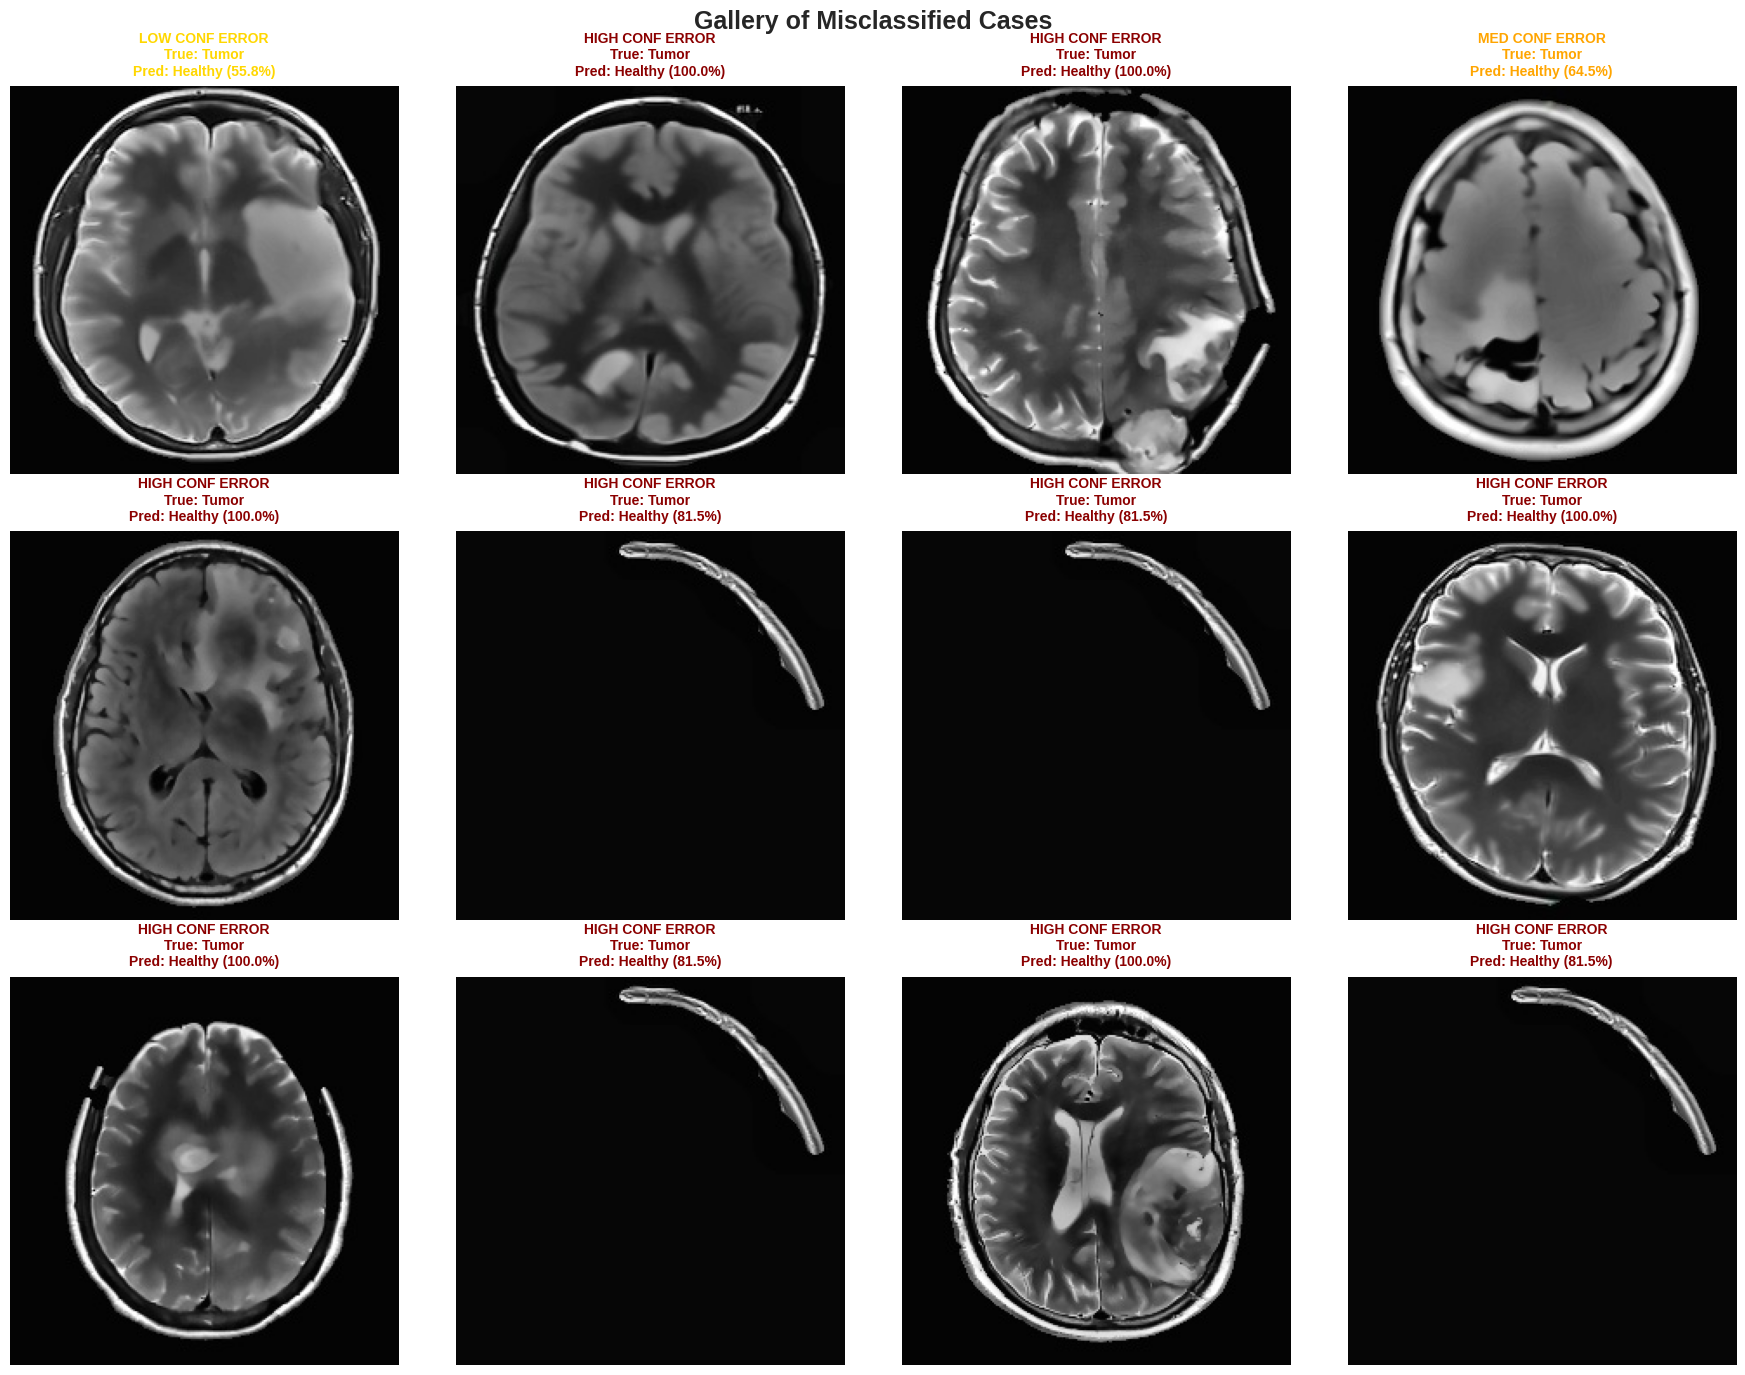

In [6]:
if len(df_errors) > 0:
    # Select diverse sample of errors
    n_samples = min(12, len(df_errors))

    # Strategy: Mix of high and low confidence
    sample_high = df_errors.nlargest(n_samples // 2, "conf_base")
    sample_low = df_errors.nsmallest(n_samples // 2, "conf_base")
    sample_errors = pd.concat([sample_high, sample_low]).sample(frac=1)  # Shuffle

    fig, axes = plt.subplots(3, 4, figsize=(18, 14))
    fig.suptitle("Gallery of Misclassified Cases", fontsize=18, fontweight="bold")
    axes = axes.flatten()

    for idx, (_, row) in enumerate(sample_errors.iterrows()):
        if idx >= 12:
            break

        ax = axes[idx]

        # Read image
        img = cv2.imread(row["path"])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display
        ax.imshow(img_rgb)
        ax.axis("off")

        # Title color based on confidence
        conf = row["conf_base"]
        if conf > 0.8:
            color = "darkred"
            label = "HIGH CONF ERROR"
        elif conf > 0.6:
            color = "orange"
            label = "MED CONF ERROR"
        else:
            color = "gold"
            label = "LOW CONF ERROR"

        # Title with information
        title = f"{label}\n"
        title += f"True: {row['true_class']}\n"
        title += f"Pred: {row['pred_class']} ({conf:.1%})"

        ax.set_title(title, fontsize=10, color=color, fontweight="bold", pad=8)

        # Color border
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)

    # Hide extra axes
    for idx in range(len(sample_errors), 12):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.savefig("../reports/error_gallery.png", dpi=150, bbox_inches="tight")
    print("\n✅ Gallery saved: reports/error_gallery.png")
    plt.show()

## 5. Data Export

We save errors to CSV for later analysis or team sharing.

In [7]:
if len(df_errors) > 0:
    # Save complete CSV
    csv_path = "../reports/error_log.csv"
    df_errors.to_csv(csv_path, index=False)
    print(f"✅ Error log exported: {csv_path}")
    print(f"   Total: {len(df_errors)} errors recorded")

    # Recalculate confusion_pairs for the summary
    confusion_pairs_export = df_errors.groupby(["true_class", "pred_class"]).size()
    confusion_pairs_export = confusion_pairs_export.sort_values(ascending=False)

    # Convert tuples to strings for JSON
    most_common_confusions = {
        f"{k[0]} → {k[1]}": int(v)
        for k, v in confusion_pairs_export.head(3).items()
    }

    # Save statistical summary
    summary = {
        "total_errors": len(df_errors),
        "mean_confidence": float(df_errors["conf_base"].mean()),
        "median_confidence": float(df_errors["conf_base"].median()),
        "high_confidence_errors": int((df_errors["conf_base"] > 0.8).sum()),
        "errors_by_class": df_errors["true_class"].value_counts().to_dict(),
        "most_common_confusions": most_common_confusions,
    }

    import json

    summary_path = "../reports/error_summary.json"
    with open(summary_path, "w") as f:
        json.dump(summary, f, indent=2)

    print(f"✅ Statistical summary: {summary_path}")

✅ Error log exported: ../reports/error_log.csv
   Total: 44 errors recorded
✅ Statistical summary: ../reports/error_summary.json


## 6. Model Improvement Recommendations

Based on error analysis, we propose specific improvements:

In [8]:
if len(df_errors) > 0:
    print("\n" + "=" * 70)
    print("RECOMMENDATIONS BASED ON ANALYSIS")
    print("=" * 70)

    # Recommendation 1: Most problematic class
    worst_class = df_errors["true_class"].value_counts().idxmax()
    worst_count = df_errors["true_class"].value_counts().max()

    print(f"\n1. FOCUS ON CLASS '{worst_class.upper()}':")
    print(f"   → {worst_count} errors ({worst_count / len(df_errors):.1%} of total)")
    print(f"   → Increase data for this class (synthesis, augmentation)")
    print(f"   → Review annotation quality in training set")

    # Recommendation 2: Most frequent confusion
    # Recalculate confusion_pairs for this section
    confusion_pairs = df_errors.groupby(["true_class", "pred_class"]).size()
    confusion_pairs = confusion_pairs.sort_values(ascending=False)
    most_common = confusion_pairs.idxmax()
    print(f"\n2. RESOLVE CONFUSION: {str(most_common[0])} ↔ {str(most_common[1])}")
    print(f"   → These classes are confused {confusion_pairs.max()} times")
    print(f"   → Implement Focal Loss to penalize these confusions")
    print(f"   → Add specific features that discriminate these classes")

    # Recommendation 3: High confidence errors
    # Recalculate high_conf_errors for this section
    high_conf_errors = df_errors[df_errors["conf_base"] > 0.8]
    high_conf_pct = (len(high_conf_errors) / len(df_errors)) * 100
    if high_conf_pct > 20:
        print(f"\n3. CALIBRATION NEEDED:")
        print(f"   → {high_conf_pct:.1f}% of errors have >80% confidence")
        print(f"   → The model is overconfident")
        print(f"   → Adjust temperature scaling more aggressively")
        print(f"   → Consider Label Smoothing (ε=0.1)")

    # Recommendation 4: High confidence in errors
    if df_errors["conf_base"].mean() > 0.6:
        print(f"\n4. HIGHLY BIASED DECISIONS:")
        print(f"   → Average confidence on errors: {df_errors['conf_base'].mean():.2%}")
        print(f"   → The model is overconfident in incorrect predictions")
        print(f"   → Implement Test Time Augmentation (TTA)")
        print(f"   → Use ensemble of 3-5 models")

    print("\n" + "=" * 70)
    print("📊 Complete dashboard generated in: reports/")
    print("📝 Next step: Implement priority recommendations")
    print("=" * 70)
else:
    print("\n🎉 NO ERRORS IN TEST SET")
    print("   The model achieves 100% accuracy.")
    print("   Consider:")
    print("   1. Validate on external dataset (domain shift)")
    print("   2. Verify test set is sufficiently challenging")
    print("   3. Evaluate with K-Fold CV to estimate variance")

print("\n✅ Complete analysis finished")


RECOMMENDATIONS BASED ON ANALYSIS

1. FOCUS ON CLASS 'TUMOR':
   → 44 errors (100.0% of total)
   → Increase data for this class (synthesis, augmentation)
   → Review annotation quality in training set

2. RESOLVE CONFUSION: Tumor ↔ Healthy
   → These classes are confused 44 times
   → Implement Focal Loss to penalize these confusions
   → Add specific features that discriminate these classes

3. CALIBRATION NEEDED:
   → 95.5% of errors have >80% confidence
   → The model is overconfident
   → Adjust temperature scaling more aggressively
   → Consider Label Smoothing (ε=0.1)

4. HIGHLY BIASED DECISIONS:
   → Average confidence on errors: 93.74%
   → The model is overconfident in incorrect predictions
   → Implement Test Time Augmentation (TTA)
   → Use ensemble of 3-5 models

📊 Complete dashboard generated in: reports/
📝 Next step: Implement priority recommendations

✅ Complete analysis finished
